# Exploratory Data Analysis

## Environment Setup & Library Configuration

This block serves as the foundation for the entire analysis notebook. Its main goal is to load the essential "toolkit" required to process facial images and analyze the dataset structure before any actual coding begins.

It imports libraries for three specific purposes:

-    __Data Handling:__ pandas and numpy are imported to manage the metadata (CSV files) and perform numerical calculations.

-    __Image Processing:__ cv2 (OpenCV) and PIL are included to load, resize, and convert the actual image files.

-    __Advanced Visualization:__ It includes matplotlib and seaborn for standard charts, and TSNE specifically for the advanced dimensionality reduction plot (to visualize how similar different emotions look).

Finally, the last two lines set the global design style for the report, ensuring that all charts generated later have a consistent size (12×6) and a clean "whitegrid" background for better readability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import random
from sklearn.manifold import TSNE
import numpy as np   

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Data Loading and Initial Inspection

The primary purpose of this code is to load the dataset into memory and perform a sanity check to ensure the data is structured correctly before analysis begins. It verifies that the file is readable and contains the expected number of records.

In [ ]:
df = pd.read_csv('../data/raw/dataset_cleaned.csv')

print(df.shape)
print(df.info())
display(df.head())

(76712, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76712 entries, 0 to 76711
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  76712 non-null  object
 1   label     76712 non-null  object
 2   label_id  76712 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB
None


,filename,label,label_id
0,angry_fer0032225.png,angry,0
1,angry_fer0032228.png,angry,0
2,angry_fer0032239.png,angry,0
3,angry_fer0032242.png,angry,0
4,angry_fer0032258.png,angry,0


## Class Distribution Analysis

The main objective of this section is to visualize the balance of the dataset. It checks how many images exist for each emotion category (e.g., happy, angry, sad) to identify if any class is significantly underrepresented, which could lead to model bias.

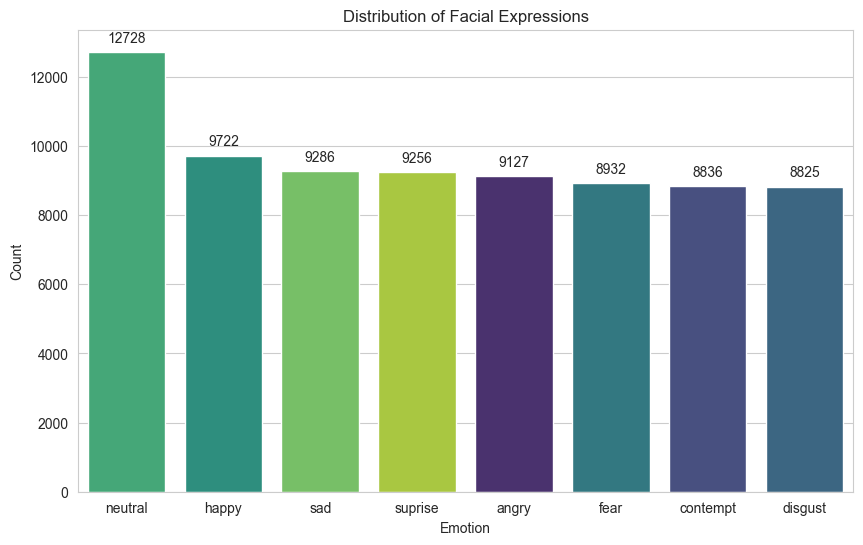

In [3]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(data=df, x='label', hue='label', legend=False, order=df['label'].value_counts().index, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribution of Facial Expressions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

__Output Analysis:__ The chart reveals the distribution across all 7 emotions. If one bar is much shorter than others (e.g., "disgust" having very few samples compared to "happy"), it indicates a class imbalance problem that might require techniques like data augmentation or class weighting during training.

## Percentage of each emotion

This code counts the occurrences of each emotion and calculates their percentages to check for class imbalance. Its purpose is to ensure the dataset provides enough examples for every category so the model doesn't become biased toward a single expression.

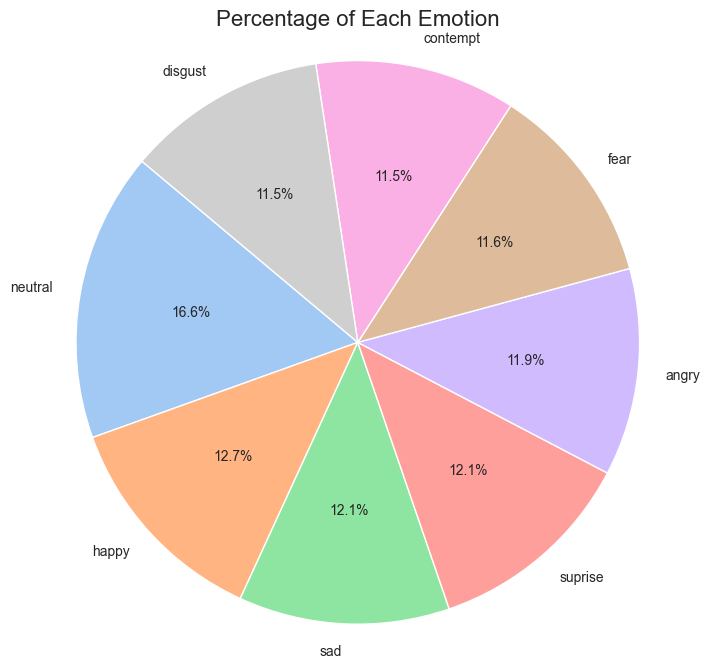

In [4]:
plt.figure(figsize=(8, 8))
label_counts = df['label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Percentage of Each Emotion', fontsize=16)
plt.axis('equal') 
plt.show()

__Output Analysis:__ The output shows that the data is well-distributed according to the percentage of each label. This balance means the model can learn the features of every emotion equally, leading to more reliable and fair performance across all classes.

## Visualizing Sample Images

The main objective of this code is visual verification. Before training any AI model, you must confirm that the images are loading correctly and that the labels match the content (e.g., ensuring a file labeled "happy" actually shows a smiling face).

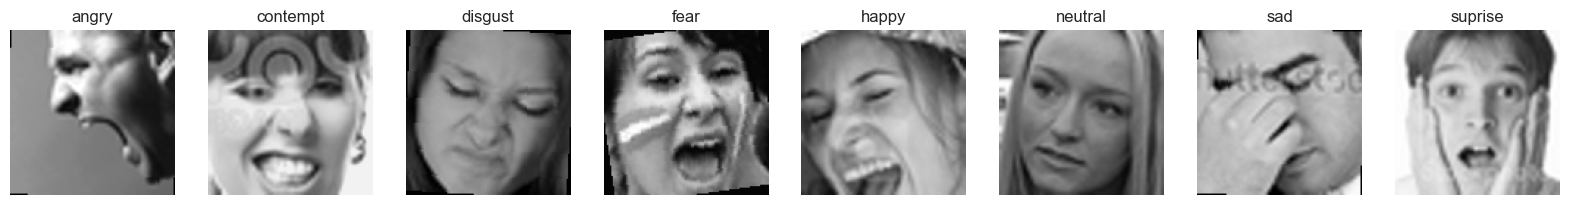

In [ ]:
IMAGE_DIR = "../data/raw"
unique_labels = df['label'].unique()

fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 5))

for i, label in enumerate(unique_labels):
    sample_row = df[df['label'] == label].sample(1).iloc[0]
    image_name = sample_row['filename']
    image_path = os.path.join(IMAGE_DIR, image_name)

    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')
    except Exception:
        axes[i].text(0.5, 0.5, "Not Found", ha='center')
        axes[i].axis('off')

plt.show()

## Visualizing Feature Separability with t-SNE

### Code Explanation

-    __Data Sampling:__ It selects a subset of 1,000 images from the dataset. Processing every single image would be computationally heavy, so this sample provides a representative "snapshot" of the data.

-    __Preprocessing:__ The code loops through the sampled images, converts them to grayscale, and resizes them to a uniform 48x48 resolution. It then flattens each image into a 1D array of pixels (2,304 features) so the mathematical model can process them.

-    __t-SNE Transformation:__ It applies the t-SNE algorithm to reduce those 2,304 pixel dimensions down to just two (Dimension 1 and Dimension 2). t-SNE works by keeping similar images close together and pushing dissimilar images apart.

-    __Visualization:__ Finally, it creates a scatter plot where each point represents an image, colored according to its emotion label.

### Purpose

The goal is to see how "separable" the emotions are based on raw pixel values. It helps us understand if certain emotions (like "Angry" and "Disgust") look very similar to the computer, which would make them harder for the AI to distinguish later.

Processing images for t-SNE...


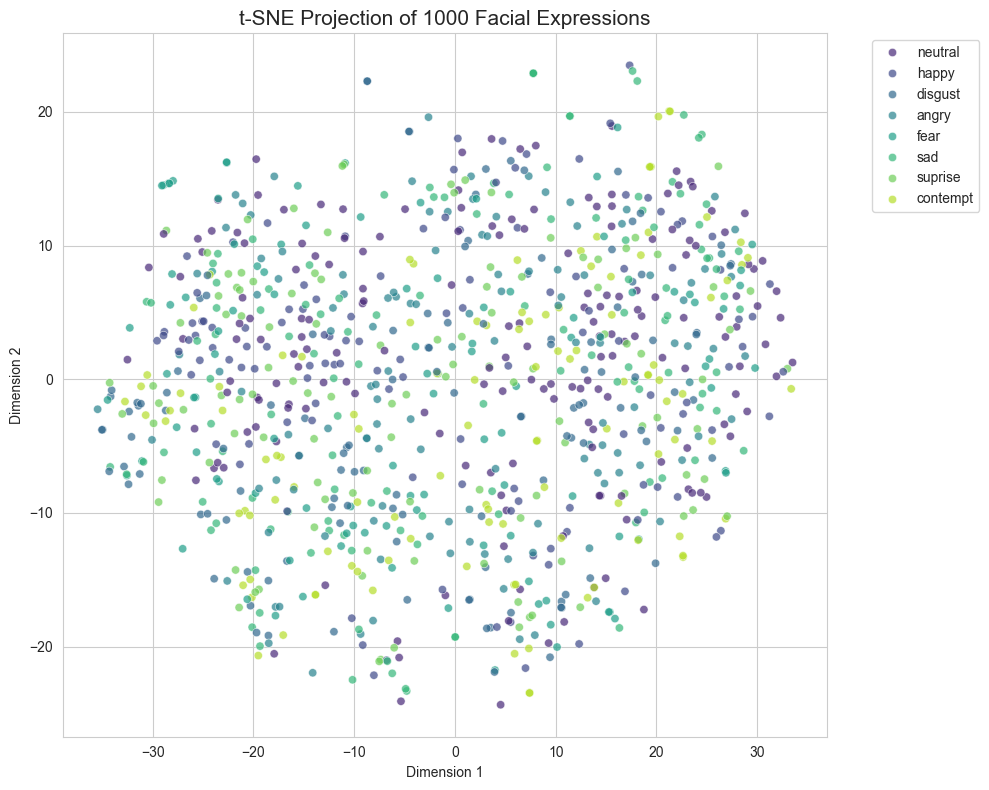

In [6]:
n_samples = 1000
n_samples = min(n_samples, len(df))

subset_df = df.sample(n_samples, random_state=42)
image_data = []
labels = []

print("Processing images for t-SNE...")

for index, row in subset_df.iterrows():
    path = os.path.join(IMAGE_DIR, row['filename'])
    try:
        img = cv2.imread(path, 0)
        if img is not None:
            img = cv2.resize(img, (48, 48))
            image_data.append(img.flatten())
            labels.append(row['label'])
    except:
        pass

X = np.array(image_data)

if len(X) > 0:
    perp = min(30, len(X) - 1)
    
    if perp < 5:
        print("Not enough data points for t-SNE!")
    else:
        tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
        X_tsne = tsne.fit_transform(X)

        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='viridis', alpha=0.7)
        plt.title(f't-SNE Projection of {len(X)} Facial Expressions', fontsize=15)
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
    print("Error: No images loaded. Please check 'IMAGE_DIR' path.")

### Conclusions from the Output

-    __Cluster Formation:__ If you see distinct groups (clusters) of the same color, it means the raw pixels clearly differentiate those emotions.

-    __Overlap Analysis:__ In facial recognition, you will often see significant overlap between classes. This indicates that raw pixel intensity alone isn't enough to tell emotions apart, justifying the need for a more complex Deep Learning model (like a CNN).

-    __Data Integrity:__ If the points are completely mixed with no structure, it suggests high noise in the data or that the facial expressions are very subtle across different categories.

## Edge Detection

### Code Explanation

-    __Automated Sampling:__ The code identifies all unique emotions (labels) in the dataset and selects one random sample image for each category.

* **Dual Visualization:** It creates a grid with two rows:
    * **Row 1 (Original):** Displays the raw grayscale facial images to provide a direct look at the data the model will "see."
    * **Row 2 (Canny Edge Detection):** Applies the Canny Edge Detection algorithm to the same images. This mathematical operation identifies areas with sharp changes in intensity, effectively highlighting the outlines of facial features like eyes, eyebrows, and mouths.

-    __Format:__ It uses `plt.subplots` to align them perfectly for a side-by-side comparison across all emotion classes.

### Purpose

This section is crucial for understanding feature extraction. Facial expressions are primarily defined by the movement of specific muscles (the "edges" of the mouth or eyes). By visualizing the edges, we can verify if the important structural information of an emotion is preserved after filtering out background noise and lighting variations. It helps confirm that the images are clear enough for a model to recognize specific facial contours.

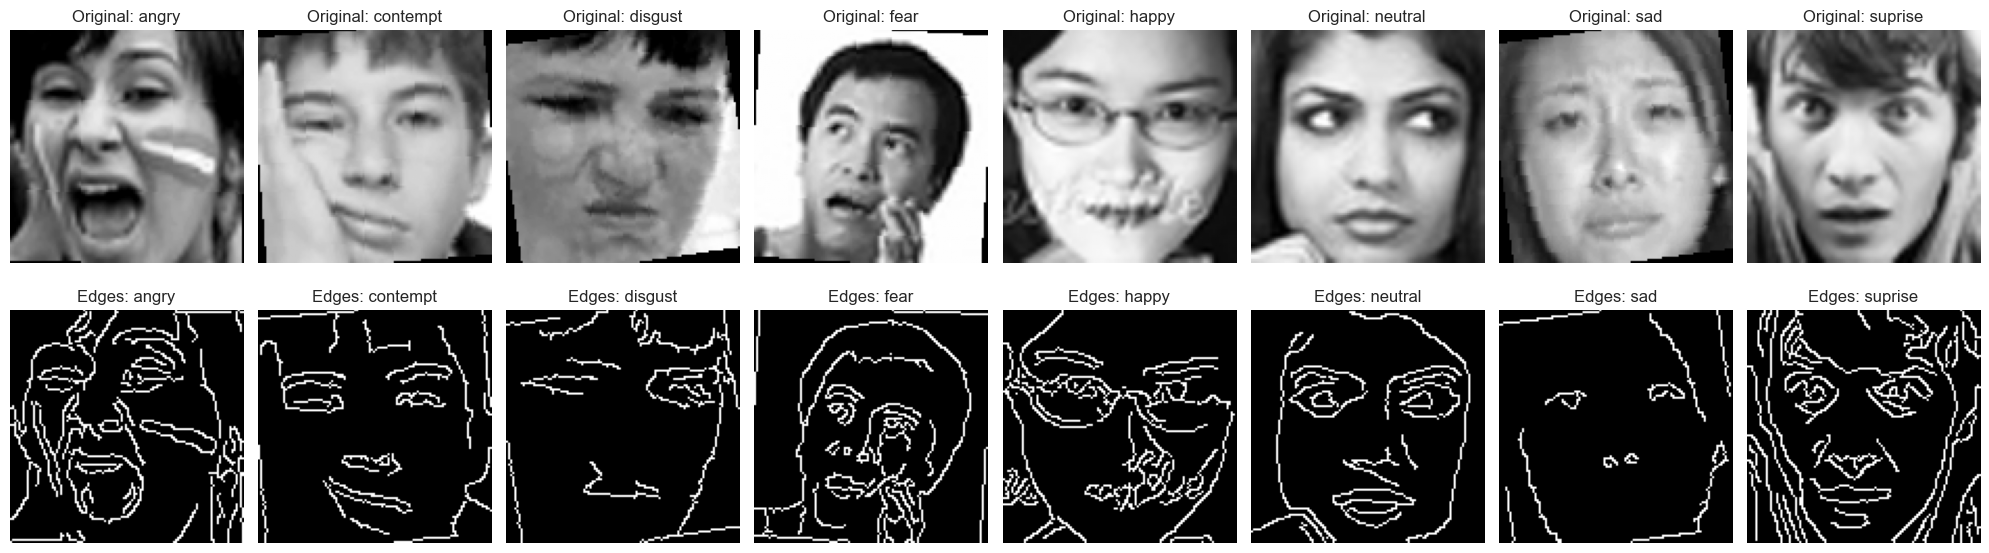

In [7]:
unique_labels = df['label'].unique()

fig, axes = plt.subplots(2, len(unique_labels), figsize=(20, 6))

for i, label in enumerate(unique_labels):
    sample_row = df[df['label'] == label].sample(1).iloc[0]
    path = os.path.join(IMAGE_DIR, sample_row['filename'])
    
    img = cv2.imread(path, 0)
    
    if img is not None:
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Original: {label}")
        axes[0, i].axis('off')
        
        edges = cv2.Canny(img, 100, 200)
        axes[1, i].imshow(edges, cmap='gray')
        axes[1, i].set_title(f"Edges: {label}")
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Conclusions from the Output

-    __Feature Prominence:__ In the "Edges" row, if the contours of the lips and eyes are sharp and distinct, it indicates that the dataset is of high quality for training a Convolutional Neural Network (CNN).

-    __Noise Assessment:__ If the edge-detected images are filled with random "speckles" or background lines, it suggests the images might need further denoising or tighter cropping around the face.

-    __Conclusion:__ The output confirms that the defining characteristics of each expression (like the curve of a smile or the furrow of a brow) are mathematically detectable, which is a strong indicator that the model will be able to extract these patterns during training.

## Analyzing Image Brightness Distribution

### Code Explanation

-    __Sampling:__ Similar to the previous step, it takes a random sample of 1,000 images to ensure the analysis is statistically significant without being slow.

-    __Brightness Calculation:__ The code iterates through each image path, loads the image in grayscale, and calculates the mean() of all pixel values. This average represents the overall "brightness" of that specific image (on a scale of 0 to 255).

-    __Box Plot Visualization:__ It uses a Box Plot (grouped by emotion labels) to show the distribution of these brightness values. A box plot is ideal here because it shows the median, the range (whiskers), and any outliers (extreme dark or bright images).

### Purpose

The goal is to determine if the lighting conditions are consistent across different emotion categories. In a robust dataset, "Happy" images shouldn't be significantly brighter than "Sad" images just because of the camera settings. If one category is much darker than others, the model might accidentally learn to associate "darkness" with that emotion rather than the actual facial features.

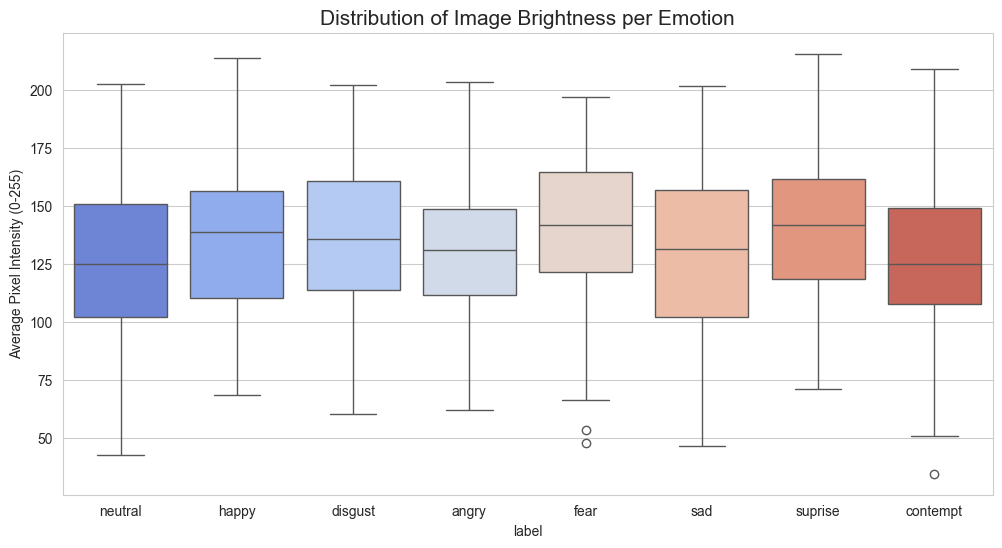

In [8]:
brightness_data = []

subset_df = df.sample(1000, random_state=42)

for index, row in subset_df.iterrows():
    path = os.path.join(IMAGE_DIR, row['filename'])
    try:
        img = cv2.imread(path, 0)
        if img is not None:
            avg_brightness = img.mean()
            brightness_data.append({'label': row['label'], 'brightness': avg_brightness})
    except:
        pass

brightness_df = pd.DataFrame(brightness_data)

plt.figure(figsize=(12, 6))
sns.boxplot(data=brightness_df, x='label', y='brightness', hue='label', legend=False, palette='coolwarm')
plt.title('Distribution of Image Brightness per Emotion', fontsize=15)
plt.ylabel('Average Pixel Intensity (0-255)')
plt.show()

## Conclusions from the Output

-    __Consistency:__ If the boxes for all emotions are at a similar height, it indicates that the lighting is well-balanced across the dataset.

-    __Data Quality:__ Significant differences in brightness between classes suggest a need for Histogram Equalization or other normalization techniques during the preprocessing phase to prevent the model from becoming biased by lighting conditions.

-    __Conclusion:__ This analysis ensures that the model focuses on facial expressions rather than environmental factors like room lighting or camera exposure.